# Tagging genes with ddlite: candidate extraction

## Introduction
In this example **Snorkel** application, we'll build a toy gene tagger from scratch. Domain-specific tagging systems traditionally take months or years to develop. They use hand-crafted model circuitry and accurate, hand-labeled training data. We'll start to build a pretty good one in a few minutes with none of those things. The generalized extraction and learning utilities provided by **Snorkel** will allow us to turn a sampling of article abstracts and some basic domain knowledge into an automated tagging system. Specifically, we want an accurate tagger for genes in academic articles. We have comprehensive dictionaries of genes, but applying a simple matching rule might yield a lot of false positives. For example, "p53" might get tagged as a gene if it refers to a page number. Our goal is to use the [data programming](https://arxiv.org/abs/1605.07723) approach to improve precision.

Here's the pipeline we'll follow:

1. Obtain and parse input data (relevant article abstracts from PubMed)
2. Extract candidates for tagging
3. Generate features
4. Create a test set
5. Write labeling functions
6. Learn the tagging model
7. Iterate on labeling functions

Parts 3 through 7 are covered in this notebook. It requires candidates extracted from `GeneTaggerExample_Extraction.ipynb`, which covers parts 1 and 2.

_Note: We run automated tests on this tutorial to make sure that it is always up to date!  However, certain interactive components cannot currently be tested automatically, and will be skipped with if-then statements using the variable below:_

In [1]:
import os
AUTOMATED_TESTING = os.environ.get('TESTING') is not None

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import cPickle, os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
np.random.seed(seed=1701)
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading candidate extractions
First, we'll load in the pickled candidates that we created in the last notebook:

In [3]:
with open('gene_tag_example/gene_tag_saved_candidates.pkl', 'r+') as f:
    candidates = cPickle.load(f)

# Labeling a test set

Next, we'd like to ideally have a _small_ amount of hand-annotated data--i.e. candidates labeled `True` of `False`--both to evaluate our end performance, and to help us develop our application.  In the former case, **we should obtain a _blind_ test set, i.e. one that we (the developer of the application) do not label or see**, for proper unbiased assesment of our system's performance.  We'll load a pre-labeled set of such "gold" test labels now, and split the corresponding candidates off into a test set:

In [4]:
# The gold labels are stored a dict mapping candidate-id -> label in {-1,1}
with open('gene_tag_example/gt/gold_labels.pkl', 'rb') as f:
    gold_label_map = cPickle.load(f)
    
# Split into train and test set
training_candidates = []
gold_candidates     = []
gold_labels         = []
for c in candidates:
    if c.id in gold_label_map:
        gold_candidates.append(c)
        gold_labels.append(gold_label_map[c.id])
    else:
        training_candidates.append(c)
gold_labels = np.array(gold_labels)
print "Training set size: %s" % len(training_candidates)
print "Gold set size: %s" % len(gold_candidates)

Training set size: 1477
Gold set size: 97


## Labeling more examples with `Viewer`

If we wanted to label more examples- perhaps, for example, to use as reference during development- we could use the `Viewer`:

In [5]:
from snorkel.viewer import SentenceNgramViewer
sentences = candidates.get_contexts()

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
if not AUTOMATED_TESTING:
    sv = SentenceNgramViewer(sentences, candidates)
else:
    sv = None

<IPython.core.display.Javascript object>

In [6]:
sv

Note that we can **navigate using the provided buttons**, or **using the keyboard (hover over buttons to see controls)**, highlight candidates (even if they overlap), and also **apply binary labels** (more on where to use this later!).  In particular, note that **the Viewer is synced dynamically with the notebook**, so that we can for example get the `id` of the candidate that is currently selected, this candidate object itself, as well as any labels we've applied.  Try it out!

Then, we can get the labels we created in the same format as we loaded before:

In [7]:
if not AUTOMATED_TESTING:
    print sv.get_labels()

{u'17217236-8:911-916': 1}


## Writing labeling functions
We'll use data programming to learn a logistic regression model which will predict the probability of a candidate entity being a true gene mention. Since our training data is not manually labeled, we'll generate many (potentially noisy) labels as a surrogate for precise, manual labels. Feature extraction and model learning are very simple in ddlite. Writing labeling functions is where the real artistry comes in. One of ddlite's goals is to enable rapid prototyping, debugging, and experimenting with labeling functions. These can be used either to create a simple standalone app, or to plug into DeepDive. Labeling functions, or LFs, are functions that take an `Candidate` object. They must return 1 (for a positive label), 0 (for abstaining), or -1 (for a negative example). For now, we'll write a few simple LFs to get started:

* The first, second, and third LFs return a positive label if the lemma "gene", "mutant", or "express" appear in a window around the mention, respectively
* The third LF returns a positive label if the dependency parent of any of the words in the mention is "mutation", and abstains otherwise
* The fourth, fifth, and sixth LF return a negative label if the mention candidate contains "DNA", "RNA", or "SNP" respectively (these are common uppercase nouns which are not genes) 

In [8]:
def LF_gene(m):
    return 1 if ('gene' in m.right_window('lemmas')) or ('gene' in m.left_window('lemmas')) else 0

def LF_gene_dp(m):
    return 1 if 'gene' in [m.sentence['lemmas'][m.sentence['dep_parents'][i] - 1] for i in m.idxs] else 0

def LF_genotype_dp(m):
    return 1 if 'genotype' in [m.sentence['lemmas'][m.sentence['dep_parents'][i] - 1] for i in m.idxs] else 0

def LF_mutant(m):
    return 1 if ('mutant' in m.right_window('lemmas')) or ('mutant' in m.left_window('lemmas')) else 0

def LF_variant(m):
    return 1 if ('variant' in m.right_window('lemmas')) or ('variant' in m.left_window('lemmas')) else 0

def LF_express(m):
    return 1 if ('express' in m.right_window('lemmas')) or ('express' in m.left_window('lemmas')) else 0

def LF_mutation(m):
    return 1 if 'mutation' in [m.sentence['lemmas'][m.sentence['dep_parents'][i] - 1] for i in m.idxs] else 0

def LF_JJ(m):
    return 1 if 'JJ' in m.right_window('poses') else 0

def LF_IN(m):
    return 1 if 'IN' in m.left_window('poses', n=1) else 0

def LF_dna(m):
    return -1 if 'DNA' in m.get_attrib_tokens('words') else 0

def LF_rna(m):
    return -1 if 'RNA' in m.get_attrib_tokens('words') else 0

def LF_snp(m):
    return -1 if 'SNP' in m.get_attrib_tokens('words') else 0

def LF_protein(m):
    return -1 if 'protein' in m.left_window('lemmas') else 0

def LF_LRB(m):
    return -1 if '-LRB-' in m.right_window('poses', 1) else 0

def LF_RRB(m):
    return -1 if '-RRB-' in m.right_window('poses', 1) else 0

def LF_dev_dp(m):
    return -1 if 'development' in [m.sentence['lemmas'][m.sentence['dep_parents'][i] - 1] for i in m.idxs] else 0

def LF_protein_dp(m):
    return -1 if 'protein' in [m.sentence['lemmas'][m.sentence['dep_parents'][i] - 1] for i in m.idxs] else 0

def LF_network_dp(m):
    return -1 if 'network' in [m.sentence['lemmas'][m.sentence['dep_parents'][i] - 1] for i in m.idxs] else 0

def LF_JJ_dp(m):
    return -1 if 'JJ' in [m.sentence['poses'][m.sentence['dep_parents'][i] - 1] for i in m.idxs] else 0

def LF_NNP(m):
    return -1 if 'NNP' in m.get_attrib_tokens('poses') else 0

Our intuition is that the few simple LFs given above won't yield a good model. We'll see this more concretely when we evaluate the labeling functions. For now, let's leave them as is. After writing the LFs, we simply collect them and apply them to mentions. If we define more LFs later, we can apply them incrementally or overwrite all the LFs so far.

In [9]:
LFs = [LF_JJ, LF_JJ_dp, LF_NNP, LF_RRB, LF_dev_dp, LF_dna, LF_express, LF_gene, LF_gene_dp,
       LF_genotype_dp, LF_mutant, LF_mutation, LF_network_dp, LF_protein, LF_protein_dp,
       LF_rna, LF_snp, LF_variant, LF_IN, LF_LRB]

## Creating a `TrainingSet`

We next create a `TrainingSet` object, which applies our labeling functions to our training set candidates, to create a "noisy training set".  This object also _featurizes_ our training set, and stores the fit featurizer:

In [11]:
from snorkel.snorkel import TrainingSet
from snorkel.features import NgramFeaturizer

training_set = TrainingSet(training_candidates, LFs, featurizer=NgramFeaturizer())

Applying LFs...
Featurizing...
LF Summary Statistics: 20 LFs applied to 1477 candidates
------------------------------------------------------------
Coverage (candidates w/ > 0 labels):		73.80%
Overlap (candidates w/ > 1 labels):		35.14%
Conflict (candidates w/ conflicting labels):	18.96%


## Analyzing the set of LFs

One way to analyze the labeling functions is to look individually at how much each one covers and overlaps and conflicts with other LFs; we can get this information as a `pandas.DataFrame` object for convenient analysis:

In [12]:
lf_stats = training_set.lf_stats()
lf_stats[:5]

,conflicts,coverage,j,overlaps
LF_JJ,0.114421,0.306703,0,0.200406
LF_JJ_dp,0.021666,0.029113,1,0.024374
LF_NNP,0.064320,0.094110,2,0.071090
LF_RRB,0.054164,0.132701,3,0.067028
LF_dev_dp,0.000677,0.000677,4,0.000677


We can now use all of the `DataFrame` helper methods to analyze our set of LFs e.g.:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117125a10>]], dtype=object)

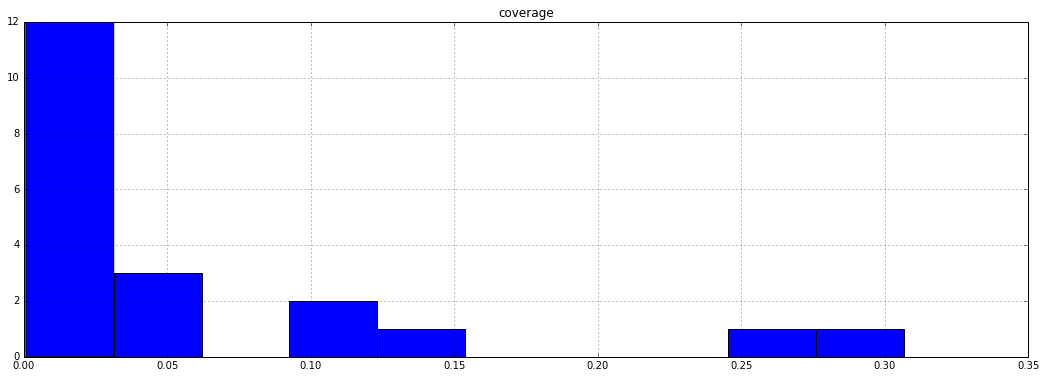

In [13]:
lf_stats.hist("coverage")

## Using the `Learner`

We next create a `Learner` object, which takes our `TrainingSet` and a `NoiseAwareModel` class.  Roughly, the learner learns a generative model of the labels over the training set we have provided, and uses this to train a _noise-aware_ discriminative model which we provide.

In [14]:
from snorkel.snorkel import Learner
from snorkel.learning import LogReg

learner = Learner(training_set, model=LogReg(bias_term=True))

We can then also do basic hyperparameter tuning using `GridSearch`, while training our model; here, we can split up our _gold_ set into a **cross-validation set** (used for this purpose) as well as a final _test_ set.  Note that for `GridSearch`, we provide a _list_ of hyperparameter names, and a _list of lists_ of values to try for each; we can also pass on other hyperparameters to keep fixed at specific values as keyword arguments after:

In [15]:
# Splitting into CV and test set
test_candidates = gold_candidates[:60]
test_labels     = gold_labels[:60]
cv_candidates   = gold_candidates[60:]
cv_labels       = gold_labels[60:]

In [16]:
from snorkel.learning_utils import GridSearch

gs       = GridSearch(learner, ['mu', 'lf_w0'], [[1e-5, 1e-7],[1.0,2.0]])
gs_stats = gs.fit(cv_candidates, cv_labels)

Testing mu = 1.00e-05, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.019762
	Learning epoch = 250	Gradient mag. = 0.023827
	Learning epoch = 500	Gradient mag. = 0.027524
	Learning epoch = 750	Gradient mag. = 0.032010
Final gradient magnitude for rate=0.01, mu=1e-05: 0.037
Applying LFs...
Featurizing...
Testing mu = 1.00e-05, lf_w0 = 2.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.029858
	Learning epoch = 250	Gradient mag. = 0.034244
	Learning epoch = 500	Gradient mag. = 0.037549
	Learning epoch = 750	Gradient mag. = 0.041404
Final gradient magnitude for rate=0.01, mu=1e-05: 0.046
Testing mu = 1.00e-07, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.019762
	Learning epoch = 250	Gradient mag. = 0.023840
	Learning epoch = 500	Gradient mag. = 0.027552
	Learning epoch = 750	Gradient mag. = 0.032058
Final gradient magnitude for rate=0.01, mu=1e-07: 0.037
Testin

We can access the results of the grid search, as a `DataFrame` object once again:

In [17]:
gs_stats

,mu,lf_w0,Prec.,Rec.,F1
0,1.000000e-05,1.0,0.62069,1.0,0.765957
1,1.000000e-05,2.0,0.62069,1.0,0.765957
2,1.000000e-07,1.0,0.62069,1.0,0.765957
3,1.000000e-07,2.0,0.62069,1.0,0.765957


Finally, we can evaluate on the test set (`GridSearch` will automatically leave in the optimal weights learned):

Applying LFs...
Featurizing...


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


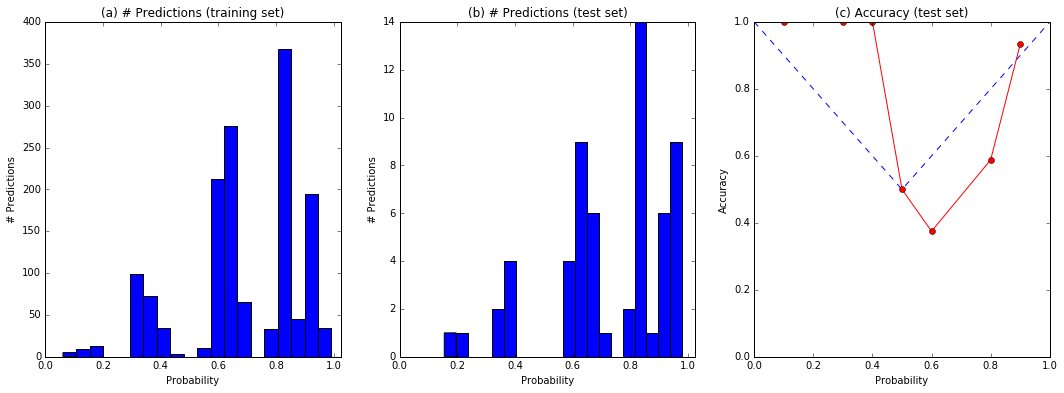

Test set size:	60
----------------------------------------
Precision:	0.615384615385
Recall:		1.0
F1 Score:	0.761904761905
----------------------------------------
TP: 32 | FP: 20 | TN: 8 | FN: 0


In [18]:
learner.test(test_candidates, test_labels)

There are also various helper functions that we can access post-learning; see documentation / docstrings in code, but for example, to see top features learned (again, returned as a `DataFrame`):

In [19]:
learner.feature_stats(n_max=10)

,j,w
DDLIB_LENGTH_1,22130,0.103152
DDLIB_POS_SEQ_[NN],2069,0.102643
DDLIB_STARTS_WITH_CAPTIAL,30726,0.091983
TDL_DEP_LABEL:MENTION[compound],2766,0.070471
DDLIB_DEP_SEQ_[compound],13748,0.070471
DDLIB_W_LEFT_POS_1_[IN],10904,0.065524
DDLIB_W_RIGHT_POS_1_[NN],26069,0.045705
DDLIB_DEP_SEQ_[nmod],27222,0.036538
TDL_DEP_LABEL:MENTION[nmod],6502,0.036538
TDL_LEMMA:PARENTS-OF-MENTION[None],15155,0.035621


## Using the `LSTM` package

Another default `NoiseAwareModel` subclass is an `LSTM`; we can also train this, using the `RepresentationLearner` (which more broadly, is the `Learner` subclass for end models that do not take featurized input, but rather learn the representation of the candidates as well):

In [20]:
from snorkel.snorkel import RepresentationLearner
from snorkel.learning import LSTM

learner2 = RepresentationLearner(training_set, model=LSTM())
learner2.train()

Training LF model...
Begin training for rate=0.01, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.100733
	Learning epoch = 250	Gradient mag. = 0.111122
	Learning epoch = 500	Gradient mag. = 0.121252
	Learning epoch = 750	Gradient mag. = 0.135912
Final gradient magnitude for rate=0.01, mu=1e-06: 0.154
Training model...
Epoch #0, Training error: 0.417062
Epoch #1, Training error: 0.417062
Epoch #2, Training error: 0.417062
Epoch #3, Training error: 0.417062
Epoch #4, Training error: 0.417062
Epoch #5, Training error: 0.417062
Epoch #6, Training error: 0.417062
Epoch #7, Training error: 0.417062
Epoch #8, Training error: 0.417062
Epoch #9, Training error: 0.417062
Epoch #10, Training error: 0.417062
Epoch #11, Training error: 0.417062
Epoch #12, Training error: 0.417062
Epoch #13, Training error: 0.417062
Epoch #14, Training error: 0.417062
Epoch #15, Training error: 0.417062
Epoch #16, Training error: 0.417062
Epoch #17, Training error: 0.417062
Epoch #18, Training error: 0.417062
Epoch 

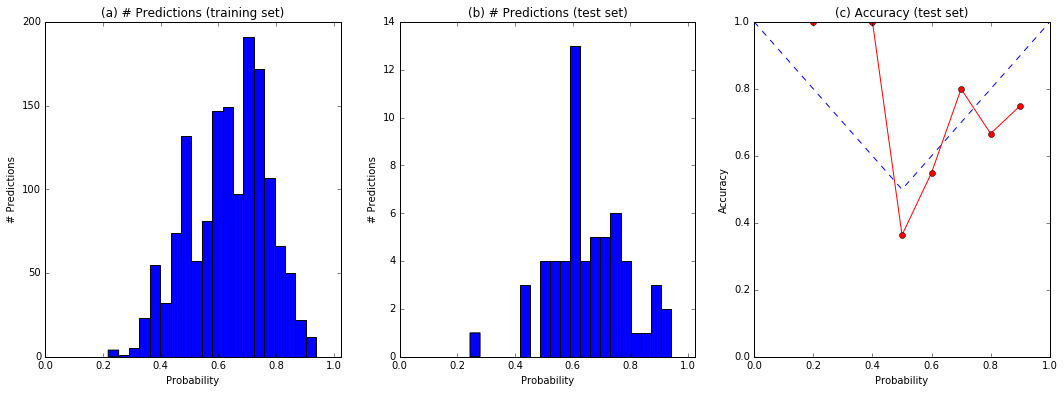

Test set size:	60
----------------------------------------
Precision:	0.603773584906
Recall:		1.0
F1 Score:	0.752941176471
----------------------------------------
TP: 32 | FP: 21 | TN: 7 | FN: 0


In [21]:
learner2.test(test_candidates, test_labels)